# Time Series Analysis of Stock Index Prices

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab
import warnings
warnings.filterwarnings('ignore')

## Acquire

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')

In [3]:
df = raw_csv_data.copy()

## Prepare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


In [5]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


- **spx** - S&P 500 (USA)
- **dax** - DAX 30 (Germany)
- **ftse** - FTSE 100 (London)
- **nikkei** - NIKKEI 225 (Japan)

In [6]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


Values for DAX and FTSE are similar, while SPX are much lower, and NIKKEI are much larger

In [7]:
df.shape

(6269, 5)

In [8]:
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

There are no nulls in the dataset

In [9]:
df.date = pd.to_datetime(df.date, dayfirst = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6269 non-null   datetime64[ns]
 1   spx     6269 non-null   float64       
 2   dax     6269 non-null   float64       
 3   ftse    6269 non-null   float64       
 4   nikkei  6269 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 245.0 KB


In [11]:
df.date.describe(datetime_is_numeric = True)

count                             6269
mean     2006-01-14 19:36:59.492759168
min                1994-01-07 00:00:00
25%                2000-01-11 00:00:00
50%                2006-01-12 00:00:00
75%                2012-01-19 00:00:00
max                2018-01-29 00:00:00
Name: date, dtype: object

In [12]:
# Setting the date column as the index
df.set_index('date', inplace=True)

In [13]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [14]:
df = df.asfreq('D')
df.isna().sum()

spx       2520
dax       2520
ftse      2520
nikkei    2520
dtype: int64

In [15]:
df = df.fillna(method = 'ffill')
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [16]:
def simplify_df(df, target):
    df = df.rename(columns = {target: 'market_value'})
    return pd.DataFrame(df["market_value"])

In [17]:
spx = simplify_df(df, 'spx')
dax = simplify_df(df, 'dax')
ftse = simplify_df(df, 'ftse')
nikkei = simplify_df(df, 'nikkei')

## Explore

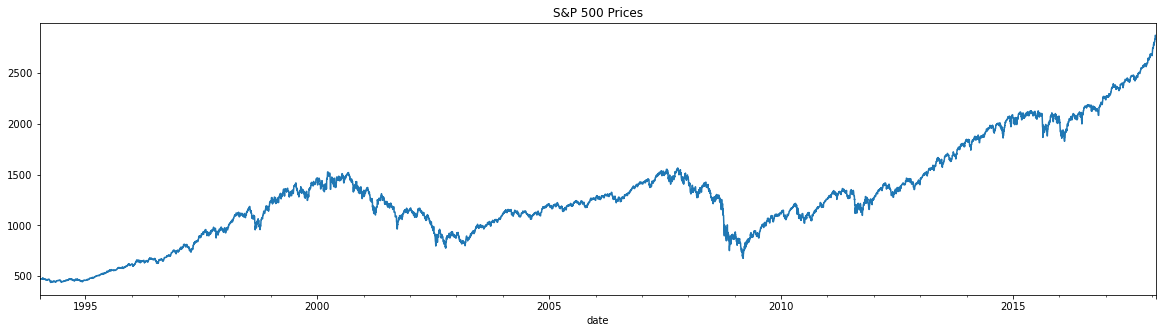

In [18]:
spx.market_value.plot(figsize = (20,5), title = 'S&P 500 Prices')
plt.show()

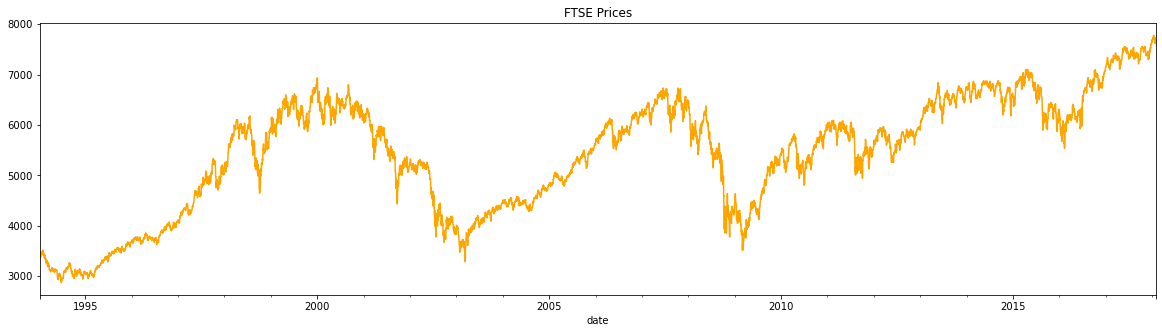

In [19]:
ftse.market_value.plot(figsize = (20, 5), title = 'FTSE Prices', color = 'orange')
plt.show()

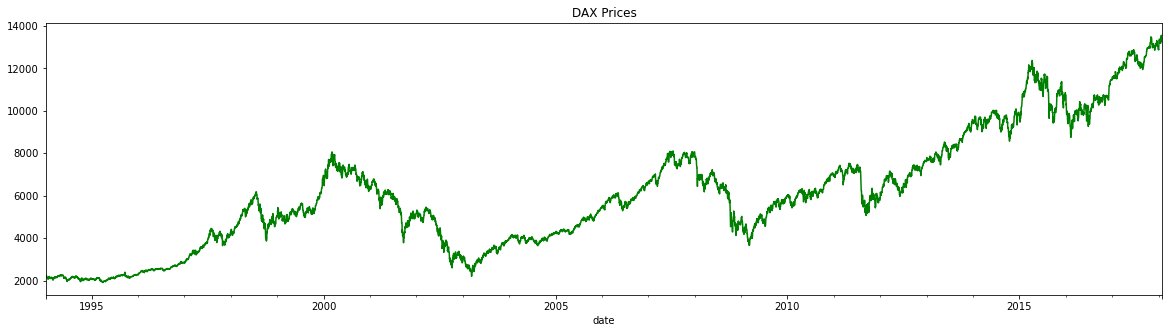

In [20]:
dax.market_value.plot(figsize = (20, 5), title = 'DAX Prices', color = 'green')
plt.show()

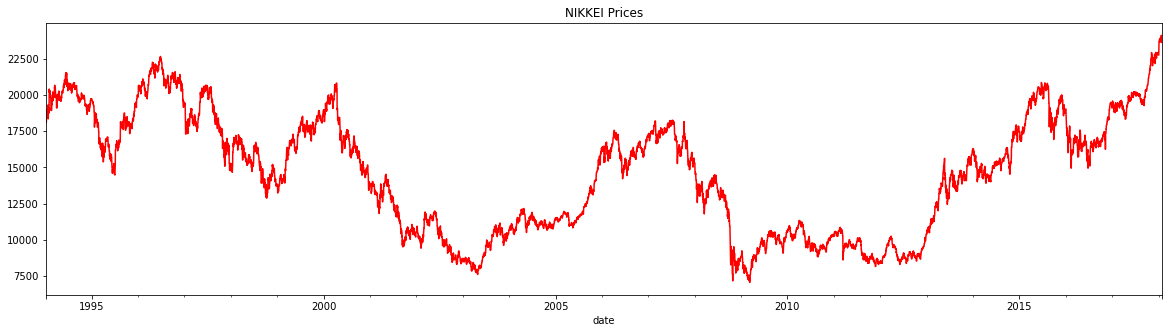

In [21]:
nikkei.market_value.plot(figsize = (20, 5), title = 'NIKKEI Prices', color = 'red')
plt.show()

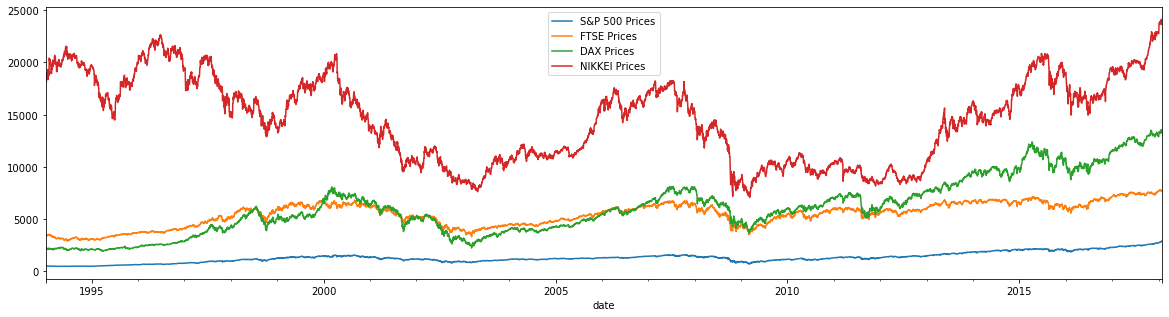

In [22]:
spx.market_value.plot(figsize = (20,5), label = 'S&P 500 Prices')
ftse.market_value.plot(figsize = (20, 5), label = 'FTSE Prices')
dax.market_value.plot(figsize = (20, 5), label = 'DAX Prices')
nikkei.market_value.plot(figsize = (20, 5), label = 'NIKKEI Prices')
plt.legend()
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
spx_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(spx)
spx_scaled = pd.DataFrame(spx_scaler.transform(spx), columns=spx.columns.values).set_index([spx.index.values])
ftse_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(ftse)
ftse_scaled = pd.DataFrame(ftse_scaler.transform(ftse), columns=ftse.columns.values).set_index([ftse.index.values])
dax_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(dax)
dax_scaled = pd.DataFrame(dax_scaler.transform(dax), columns=dax.columns.values).set_index([dax.index.values])
nikkei_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(nikkei)
nikkei_scaled = pd.DataFrame(nikkei_scaler.transform(nikkei), columns=nikkei.columns.values).set_index([nikkei.index.values])

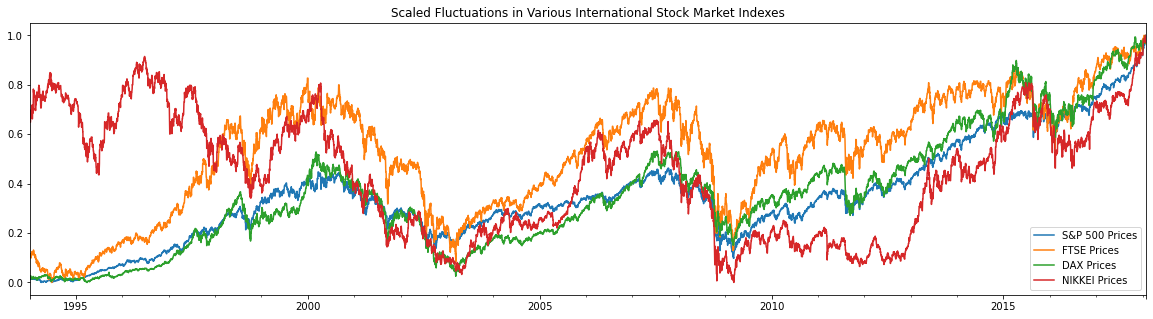

In [25]:
spx_scaled.market_value.plot(figsize = (20,5), label = 'S&P 500 Prices')
ftse_scaled.market_value.plot(figsize = (20, 5), label = 'FTSE Prices')
dax_scaled.market_value.plot(figsize = (20, 5), label = 'DAX Prices')
nikkei_scaled.market_value.plot(figsize = (20, 5), label = 'NIKKEI Prices')
plt.title('Scaled Fluctuations in Various International Stock Market Indexes')
plt.legend()
plt.show()

### QQ (Quantile-Quantile Plot) and Histogram Distribution
Showcases how well the data approximates a normal distribution

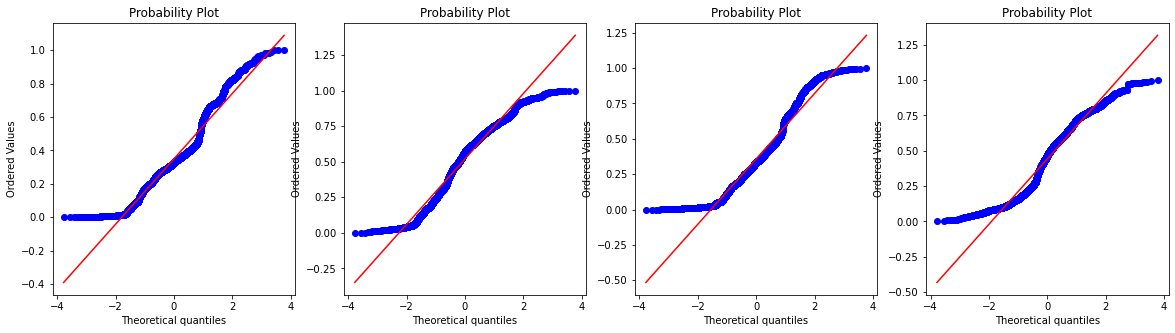

In [35]:
plt.figure(figsize= (20, 5))
plt.subplot(1, 4, 1)
scipy.stats.probplot(spx_scaled.market_value, plot = pylab)

plt.subplot(1, 4, 2)
scipy.stats.probplot(ftse_scaled.market_value, plot = pylab)

plt.subplot(1, 4, 3)
scipy.stats.probplot(dax_scaled.market_value, plot = pylab)

plt.subplot(1, 4, 4)
scipy.stats.probplot(nikkei_scaled.market_value, plot = pylab)
pylab.show()

More values around the lower and upper values than would be seen in a normal distribution. The data is not normally distributed.

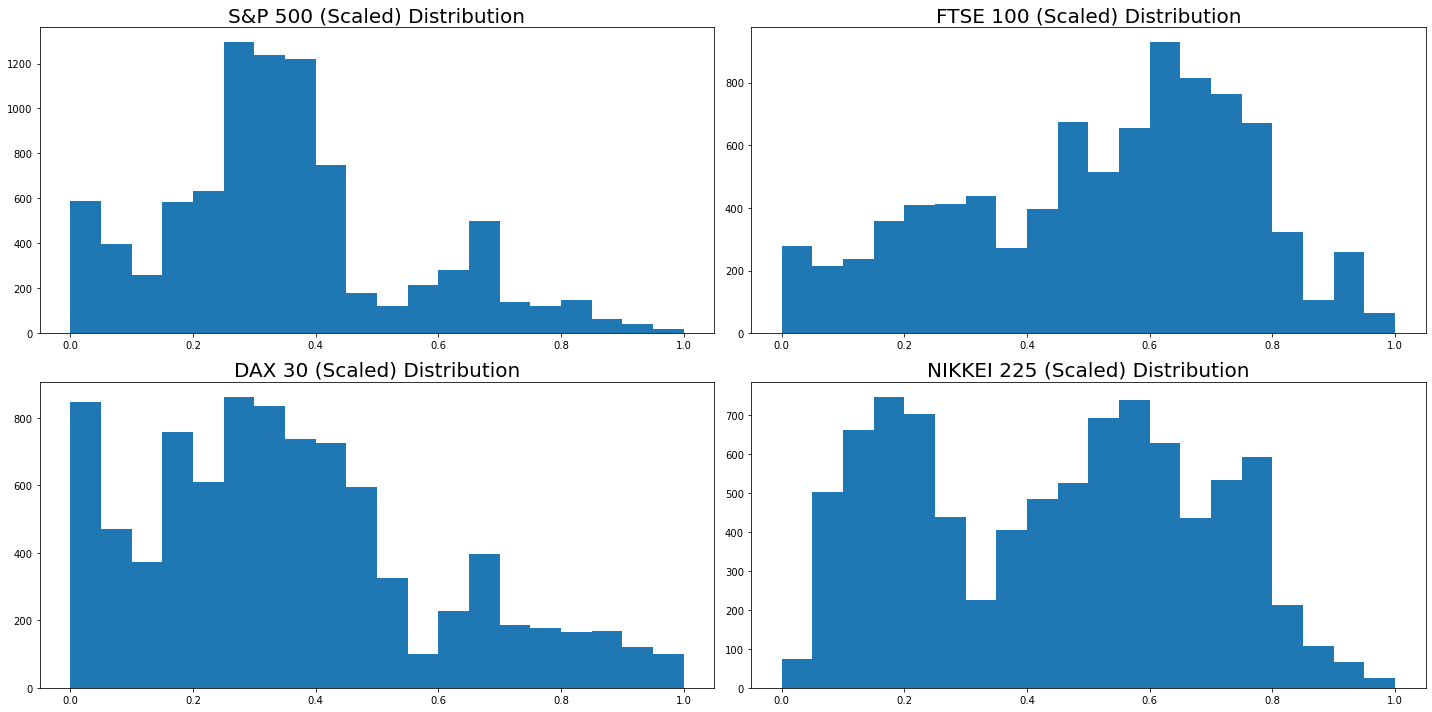

In [66]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.hist(spx_scaled.market_value, bins = 20)
plt.title('S&P 500 (Scaled) Distribution', size = 20)

plt.subplot(2, 2, 2)
plt.hist(ftse_scaled.market_value, bins = 20)
plt.title('FTSE 100 (Scaled) Distribution', size = 20)

plt.subplot(2, 2, 3)
plt.hist(dax_scaled.market_value, bins = 20)
plt.title('DAX 30 (Scaled) Distribution', size = 20)

plt.subplot(2, 2, 4)
plt.hist(nikkei_scaled.market_value, bins = 20)
plt.title('NIKKEI 225 (Scaled) Distribution', size = 20)

plt.tight_layout()
plt.show()

### Splitting the Data
As a general rule, we should split the data first, and only do an exploration on our train data set, but as this entire exercise is more for practice, we will ignore some of those requirements. 

We will focus on the S&P 500 data for now.

In [47]:
size = int(len(df) * 0.8)
spx_train = spx.iloc[:size]
spx_test = spx.iloc[size:]

In [51]:
spx_train.shape, spx_test.shape

((7031, 1), (1758, 1))

In [52]:
spx_train.tail(1)

,market_value
date,
2013-04-07,1553.27893


In [53]:
spx_test.head(1)

,market_value
date,
2013-04-08,1563.071269


## An Exploration in White Noise

In [54]:
wn = np.random.normal(loc = spx_train.market_value.mean(), scale = spx_train.market_value.std(), size = len(spx_train))

In [58]:
spx_train['wn'] = wn

In [61]:
spx_train.describe()

,market_value,wn
count,7031.000000,7031.000000
mean,1091.601131,1091.609614
std,292.663842,293.499295
min,438.920000,146.046195
25%,915.300000,895.038669
50%,1144.108392,1096.510518
75%,1316.212477,1287.412423
max,1570.252238,2193.564051


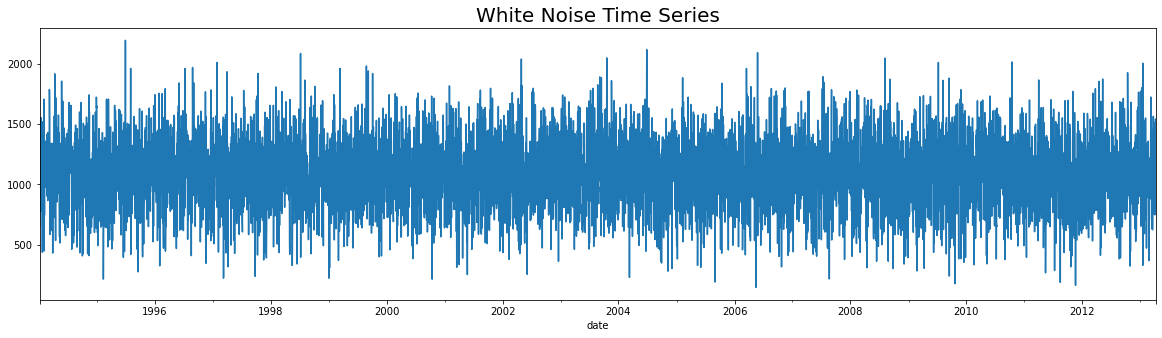

In [67]:
spx_train.wn.plot(figsize=(20,5))
plt.title('White Noise Time Series', size = 20)
plt.show()

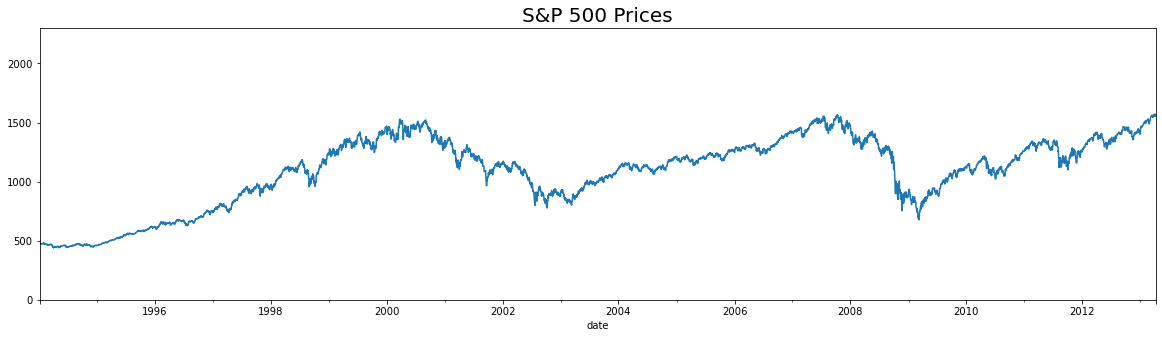

In [68]:
spx_train.market_value.plot(figsize=(20,5))
plt.title('S&P 500 Prices', size = 20)
plt.ylim(0, 2300)
plt.show()

Both the random noise time series and the S&P 500 time series have approximately the same mean and standard deviation, but it is clear that there is a pattern to the S&P 500 data, while there is no pattern present in the white noise time series.

## Random Walk

A special type of time-series, where values tend to persist over time and the differences between periods are simply white noise. 

In [69]:
rw = pd.read_csv('RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index('date', inplace = True)
rw = rw.asfreq('D')

In [70]:
rw.describe()

,price
count,7029.000000
mean,1269.648367
std,443.999180
min,574.382397
25%,931.488599
50%,1155.773451
75%,1488.957260
max,2715.508720


In [71]:
spx_train['rw'] = rw.price

In [72]:
spx_train.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,660.696461,1122.139662
1994-01-08,469.90,813.121669,1135.238562
1994-01-09,469.90,907.958147,1109.897831
1994-01-10,475.27,1088.914319,1080.347860
1994-01-11,474.13,1189.698807,1082.095245


In [90]:
spx_train.rw.isna().sum()

2

In [91]:
spx_train = spx_train[spx_train.rw.isna() == False]

market_value    0
wn              0
rw              0
dtype: int64

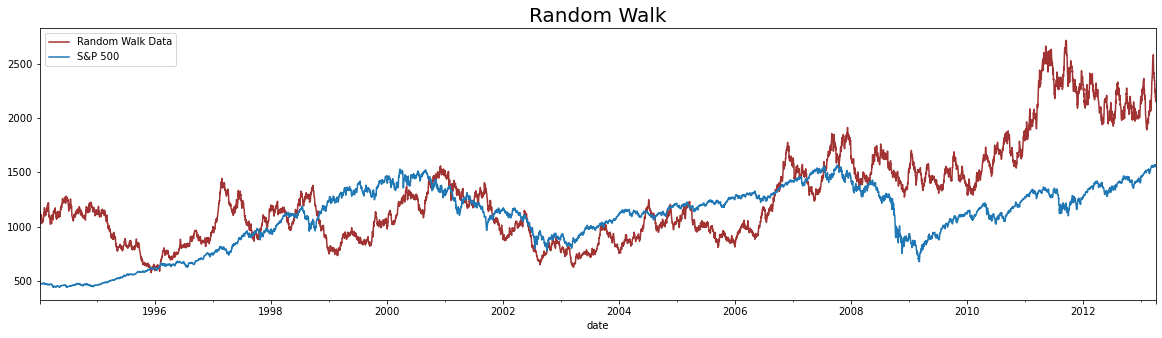

In [92]:
spx_train.rw.plot(figsize=(20,5), label = 'Random Walk Data', color = 'darkred', alpha = .8)
spx_train.market_value.plot(label = 'S&P 500')
plt.title('Random Walk', size = 20)
plt.legend()

plt.show()

The random walk data significantly differs from the white noise data. For every point in this data, the previous day + a random residual was generated. This allows the data to "walk" in random directions. The random walk data appears to have more in common with the S&P 500 data than the white noise time series we observed earlier. 

Data that mimics a random walk cannot be reliable predicted very far into the future. Only the prices of t-1 can predict t with any meaningful accuracy, and only the prices of t can predict the prices of t+1. If future prices can be predicted with good accuracy, then investors will take advantage of those prices, causing the market to price in the supposed predictability of the pricing and eliminating the potential for profit. After all, for every buyer there must be a seller, and if the future looks good to the buyer, then it also would look good to the seller, and the seller would not be willing to voluntarily abandon a stock right when it is ready to increase. These effects, compounded over many investors causes the market to behave efficiently, that is, there is no significant opportunity for arbitrage. 

Random Walk Characteristics
- Small variations between consecutive time periods.
- Cyclical increases and decreases in short periods of time.
- The differences between periods are simply white noise.
- The best estimator for today's value is yesterday's value.
- The best estimator for tomorrow's value is today's value.

## Stationarity

Taking consecutive samples of data of the same size should have the same covariances. This is also known as "covariance" stationarity or "weak-form" stationarity. 

Assumptions:
- Constant mean
- Constant variance
- Consistent covariance beween periods of the same size

With "strict" stationarity, samples of identical size should have perfectly identical distributions. We rarely observe this in the world, so when the term stationarity is used, it generally refers to "covariance" stationarity. 

To conduct accurate time series analysis, it is vital to determine if the data follows a stationarity or non-stationarity process. 

The Dickey-Fuller test and its variants can determine stationarity. 

$H_0$: One-lag-autocorrelation-coefficient < 1 (Non-stationarity)

$H_a$: One-lag-autocorrelation-coefficient = 1 (Stationarity)

In [93]:
sts.adfuller(spx_train.market_value)

(-1.7356734018666775,
 0.4128324796561487,
 27,
 7001,
 {'1%': -3.4312843949833014,
  '5%': -2.8619529275228763,
  '10%': -2.5669897973472926},
 53593.91537679106)

Test statistic = -1.74

p-value = 0.413 (in this test, the p-value is very high)

No. of lags used = 27 (there is some autocorrelation going back 27 periods)

No. of observations used in the analysis: 7003 

Values from the Dickey-Fuller table:
- 1% critical value: -3.43
- 5% critical value: -2.86
- 10% critical value: -2.57

The t-statistic is greater than all of the critical values, thus for all of these levels of significance, we fail to reject the null. 

Maximized information criteria provided there is some apparent autocorrelation: 53607
- The lower the values, the easier it is to make predictions for the future

In [94]:
sts.adfuller(spx_train.wn)

(-85.60594569591044,
 0.0,
 0,
 7028,
 {'1%': -3.4312808039348894,
  '5%': -2.8619513408164483,
  '10%': -2.566988952715846},
 99312.94457262768)

When comparing this to the white noise time series, we see that in the white noise series:
- There is a very low p-value (supports rejecting the null, which makes sense because white noise has stationarity)
- Additionally, since there is no autocorrelation in white noise, there should be no lags involved in the regression, and we see this to be true (No. of lags = 0)

In [95]:
sts.adfuller(spx_train.rw)

(-1.5198946901184296,
 0.5236477720694194,
 0,
 7028,
 {'1%': -3.4312808039348894,
  '5%': -2.8619513408164483,
  '10%': -2.566988952715846},
 62547.63026051087)

P-value is high, so we don't have significant evidence to identify this time series as stationary. We fail to reject the null. 

More often the not, random walk intervals of the same size differ significantly, due to the uncertainty of the process. We expect Random Walks to be a non-stationary process. 

## Seasonality

Certain trends will appear on a cyclical basis. 

Decomposition will split up the series into three effects:
1. Trend
2. Seasonal
3. Residual

**"Naive" Decomposition**
- We expect a linear relationship between the three parts
    - Additive: observed = trend + seasonal + residual
    - Multiplicative: observed = trend * seasonal * residual

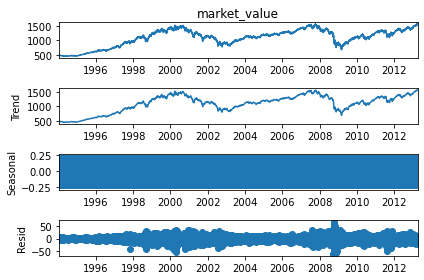

In [100]:
s_dec_additive = seasonal_decompose(spx_train.market_value, model = 'additive')
s_dec_additive.plot()
plt.show()m

The seasonal plot looks like a rectangle. This is because the values are constantly osscilating back and forth. There is no concrete cyclical pattern determined by using naive decompososition. The residuals vary greatly during the dotcom and housing bubbles in 2000 and 2008. 

There does not appear to be any seasonality in the data. 

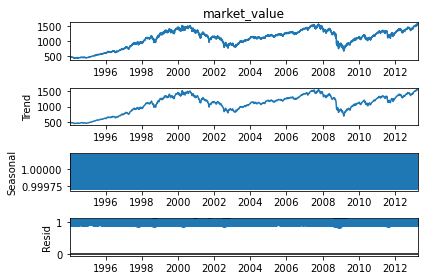

In [101]:
s_dec_multiplicative = seasonal_decompose(spx_train.market_value, model = 'multiplicative')
s_dec_multiplicative.plot()
plt.show()

Similar to the addiitve approach, the multiplicative approach also shows no apparent seasonality in S&P 500 values. 

## Autocorrelation (ACF)
The correlation between a sequence from several periods ago and the actual data. 

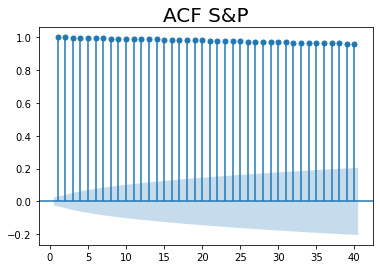

In [102]:
sgt.plot_acf(spx_train.market_value, lags = 40, zero = False)
plt.title('ACF S&P', size = 20)
plt.show()

Autocorrelation for the first 40 lags are quite high, ranging from around .9 to 1.0. The band for significance is well below these values, suggesting that the autocorrelation is significantly present. 

This suggests that prices even a month back can serve a decent estimators. 

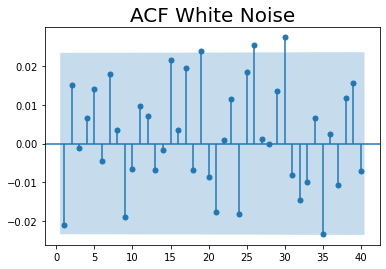

In [103]:
sgt.plot_acf(spx_train.wn, lags = 40, zero = False)
plt.title('ACF White Noise', size = 20)
plt.show()

The values for these lags are both positive an negative, unlike the S&P data which only contained positive correlations. Furthermore, the majority of these values fall within the significance band. This suggests that any correlation is due to random chance. 

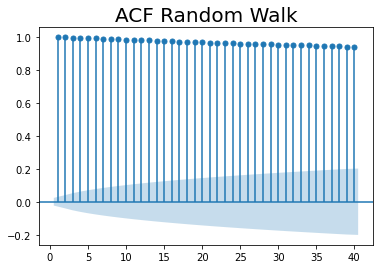

In [104]:
sgt.plot_acf(spx_train.rw, lags = 40, zero = False)
plt.title('ACF Random Walk', size = 20)
plt.show()

The values for the random walk look similar to the S&P 500 data, which also supports our assertion that the S&P 500 data is a random walk. Naturally, the way the random walk is generated is by determining the next value based on the previous value plus a random residual. If the residual is exceptionally large, the plot might begin to look more like white noise. In this case, the residuals are small enough that the even a lag of 40 still strongly correlates. 

## The Partial Autocorrelation Function (PACF)

Autocorrelation coefficients capture secondhand effects. For example, at a lag of 1, the lagging value is itself influenced by the values at lag of 2 and lag of 3 and so on. To find how a single point of data is ONLY related to a lagged version of itself, we need to compute the partial autocorrelation function. 

In [ ]:
sgt.plot_pacf()